In [11]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers, losses
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Activation, Flatten, MaxPooling2D,Activation
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

## Data fetching and understand the train/test splits

In [2]:
#Opening the SVHN file in read mode
h5f = h5py.File('SVHN_single_grey1.h5','r')
#Gettting the train and test splits
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
#Closing the file
h5f.close()

### Data Transformation

In [3]:
num_classes = 10
X_train = X_train.reshape(42000, 1024)    # 1024 = 32 X 32 the size of each image. There are 42000 images for training
X_test = X_test.reshape(18000, 1024)      # Images are flattended out into a vector of 1024 elements
X_train = X_train.astype('float32')      # Change the data type to float from integer (0 - 255)
X_test = X_test.astype('float32')
X_train /= 255                           # Scale the data between 0 and 1
X_test /= 255
original_y_train = y_train
original_y_test = y_test
y_train = tf.keras.utils.to_categorical(y_train, num_classes)   # Converting the target into categorical which is stored as numeric
y_test = tf.keras.utils.to_categorical(y_test, num_classes)     # Keras converst these into 1-hot coded vectors as these are lables

## Implement and apply a deep neural network classifier (including feedforward neural network, RELU, activations)

In [4]:
batch_size = 200
epochs = 30

def create_dense(layer_sizes):
    model = Sequential(name = f'{len(layer_sizes)}_layers_without_BN')
    model.add(Dense(layer_sizes[0], activation='relu', input_shape=(1024,)))

    for s in layer_sizes[1:]:
        model.add(Dense(units = s, activation = 'relu'))

    model.add(Dense(units=num_classes, activation='softmax'))
    return model

def evaluate(model, batch_size=batch_size, epochs=epochs):
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=False)
    loss,accuracy  = model.evaluate(X_test, y_test, verbose=False)
    
    print("Model accuracy : ", accuracy)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy / loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation','loss'], loc='best')
    plt.show()
    

Model: "2_layers_without_BN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 330,762
Trainable params: 330,762
Non-trainable params: 0
_________________________________________________________________
Model accuracy :  0.79727775


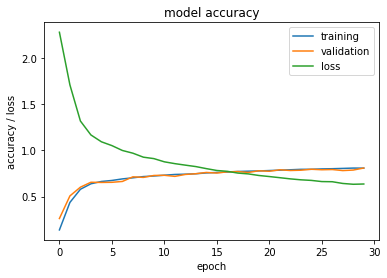

Model: "3_layers_without_BN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total params: 396,554
Trainable params: 396,554
Non-trainable params: 0
_________________________________________________________________
Model accuracy :  0.8096111


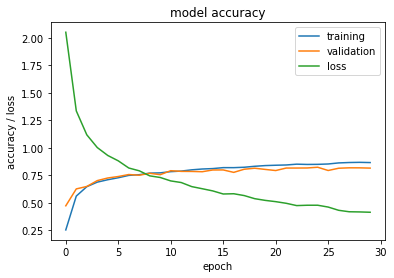

In [5]:
for layers in range(2,4):
    model = create_dense([256] * layers)
    evaluate(model)

### Implement batch normalization for training the neural network

In [6]:
batch_size = 200
epochs = 30

def create_dense(layer_sizes):
    model = Sequential(name = f'{len(layer_sizes)}_layers_with_BN')
    model.add(Dense(layer_sizes[0], activation='relu', input_shape=(1024,)))
    #Adding batch normalization
    model.add(BatchNormalization(name = 'Batch_Normalization'))
    for s in layer_sizes[1:]:
        model.add(Dense(units = s, activation = 'relu'))

    model.add(Dense(units=num_classes, activation='softmax'))
    return model

def evaluate(model, batch_size=batch_size, epochs=epochs):
    model.summary()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=False)
    loss,accuracy  = model.evaluate(X_test, y_test, verbose=False)
    
    print("Model accuracy : ", accuracy)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy / loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation','loss'], loc='best')
    plt.show()
    

Model: "2_layers_with_BN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               262400    
_________________________________________________________________
Batch_Normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 331,786
Trainable params: 331,274
Non-trainable params: 512
_________________________________________________________________
Model accuracy :  0.79344445


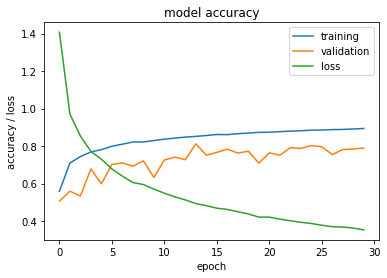

Model: "3_layers_with_BN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               262400    
_________________________________________________________________
Batch_Normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 397,578
Trainable params: 397,066
Non-trainable params: 512
_________________________________________________________________
Model accuracy :  0.7659444


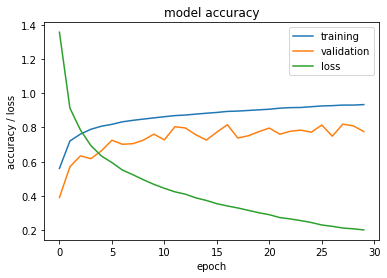

In [7]:
for layers in range(2,4):
    model = create_dense([256] * layers)
    evaluate(model)

### Hyperparameter Tuning
### Adding 4 layers with a learning rate of 0.001

In [12]:
def nn_model():
    # create model
    model = Sequential()  
    model.add(BatchNormalization(input_shape = (1024,)))  ### Batch_Norm Layer
    
    model.add(Dense(256, activation='relu')) ###Multiple Dense units with Relu activation
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    adam = optimizers.Adam(lr=1e-3)
    model.compile(loss=losses.categorical_crossentropy, optimizer=adam, metrics=['accuracy']) ### Loss function = Categorical cross entropy
    return model

# build the model
model = nn_model()

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=200, verbose=2)

# Final evaluation of the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

model.summary()

Train on 42000 samples, validate on 18000 samples
Epoch 1/30
42000/42000 - 2s - loss: 1.5438 - accuracy: 0.4745 - val_loss: 1.2707 - val_accuracy: 0.6450
Epoch 2/30
42000/42000 - 1s - loss: 0.9676 - accuracy: 0.6997 - val_loss: 0.8967 - val_accuracy: 0.7267
Epoch 3/30
42000/42000 - 1s - loss: 0.8248 - accuracy: 0.7434 - val_loss: 0.8190 - val_accuracy: 0.7524
Epoch 4/30
42000/42000 - 1s - loss: 0.7394 - accuracy: 0.7700 - val_loss: 0.7543 - val_accuracy: 0.7747
Epoch 5/30
42000/42000 - 1s - loss: 0.6859 - accuracy: 0.7869 - val_loss: 0.7397 - val_accuracy: 0.7816
Epoch 6/30
42000/42000 - 1s - loss: 0.6262 - accuracy: 0.8068 - val_loss: 0.6940 - val_accuracy: 0.7971
Epoch 7/30
42000/42000 - 1s - loss: 0.5900 - accuracy: 0.8174 - val_loss: 0.7081 - val_accuracy: 0.7938
Epoch 8/30
42000/42000 - 1s - loss: 0.5513 - accuracy: 0.8302 - val_loss: 0.6811 - val_accuracy: 0.8033
Epoch 9/30
42000/42000 - 1s - loss: 0.5224 - accuracy: 0.8378 - val_loss: 0.6782 - val_accuracy: 0.8072
Epoch 10/30
42

In [13]:
print('Final Test Accuracy: ', accuracy)

Final Test Accuracy:  0.83433336


### Print the classification accuracy metrics [ Print Both Classification report and Confusion Matrix ]

In [14]:
#Getting the predicted values using the model from the second iteration
y_predict = model.predict(X_test)

#Converting predicted values from 10D to 1D
y_pred = []
for val in y_predict:
    y_pred.append(np.argmax(val))
    
#Converting test values from 10D to 1D
y_test_norm = []
for val in y_test:
    y_test_norm.append(np.argmax(val))

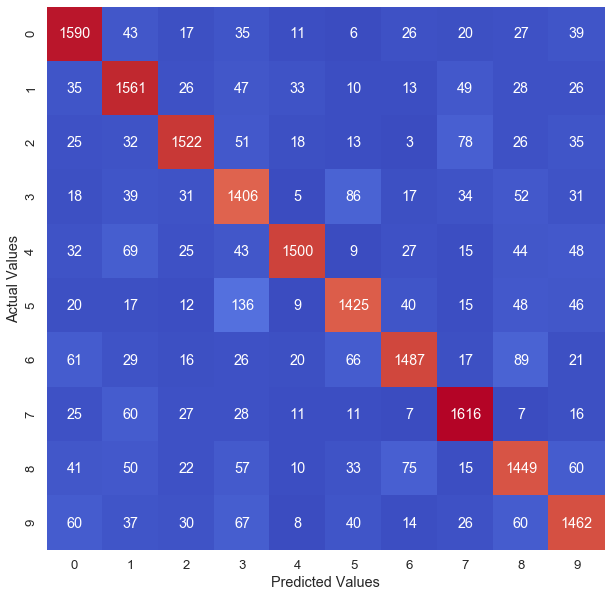

In [15]:
#Printing the confusion matrix
from sklearn import metrics
import seaborn as sns
plt.figure(figsize = (10,10)); sns.set(font_scale=1.2)
sns.heatmap(metrics.confusion_matrix(y_test_norm,y_pred), annot = True, fmt='d', cbar = False, cmap = 'coolwarm')
plt.xlabel('Predicted Values'); plt.ylabel('Actual Values')
plt.show()

In [16]:
#Printing the classification report
print(metrics.classification_report(y_test_norm,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1814
           1       0.81      0.85      0.83      1828
           2       0.88      0.84      0.86      1803
           3       0.74      0.82      0.78      1719
           4       0.92      0.83      0.87      1812
           5       0.84      0.81      0.82      1768
           6       0.87      0.81      0.84      1832
           7       0.86      0.89      0.88      1808
           8       0.79      0.80      0.80      1812
           9       0.82      0.81      0.81      1804

    accuracy                           0.83     18000
   macro avg       0.84      0.83      0.83     18000
weighted avg       0.84      0.83      0.83     18000



### Summary
1. The final accuracy that we were able to obtain from the model was ~83%
2. We have chosen to optimize the learning rate only, but there is further scope to optimize other parameters.
3. Looking at the confusion matrix we can see that the model has trouble differentiating the numbers 5 & 3.
4. The classification report shows an average recall of 0.83 and an average precision of 0.84.
5. The final training accuracy at the end of 30 epochs was 91% which is different from the test accuracy (~83%) by ~8%. This is an acceptable difference and hence we can say that the model is not overfit.